In [2]:
%matplotlib inline

import pandas as pd
import datetime
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import statistics
from scipy import signal
import random
import uuid
import json

In [204]:
#Model parameters
num_machines = 10
num_prod_lines = 5
cyclical_maintenance = 30 #number of days

fault_prob = [0.001, 0.003, 0.005]

#To be decided if the numbers are per day or per hour
scenarios = {
    "normal":
    {
        "avg_yield": 1500,
        "std_yield": 5,
        "avg_perc_defects": 0.01,
        "std_perc_defects": 0.001,
        "avg_energy_cons": 10000,
        "std_energy_cons": 200
    },
    "abnormal": 
    {
        "avg_yield": 1500,
        "std_yield": 10,
        "avg_perc_defects": 0.03,
        "std_perc_defects": 0.003,
        "avg_energy_cons": 20000,
        "std_energy_cons": 500,
    },
    "highly_abnormal": 
    {
        "avg_yield": 1500,
        "std_yield": 20,
        "avg_perc_defects": 0.05,
        "std_perc_defects": 0.005,
        "avg_energy_cons": 30000,
        "std_energy_cons": 500,
    },
    "breakdown": 
    {
        "avg_yield": 0,
        "std_yield": 0,
        "avg_perc_defects": 0,
        "std_perc_defects": 0,
        "avg_energy_cons": 0,
        "std_energy_cons": 0,
    }
}

In [4]:
def gaussian_distr(mean, std, size):
    return np.random.normal(loc=mean, scale=std, size=size)

def possoin_distr(prob, size):
    return np.random.poisson(lam=prob, size=size)

a = gaussian_distr(scenarios["normal"]["avg_yield"], scenarios["normal"]["std_yield"], 10000)
b = gaussian_distr(scenarios["normal"]["avg_perc_defects"], scenarios["normal"]["std_perc_defects"], 10000)
#print(a)

In [5]:
def plot_hist(data, step, title):
    fig, ax = plt.subplots()
    #plt.xlabel("a")
    #plt.ylabel(r"b")
    ax.grid()
    plt.hist(data, bins=np.arange(data.min(), data.max(), step))
    plt.title(title)
    plt.show();

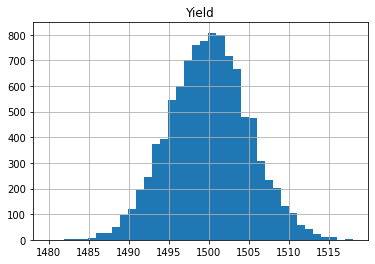

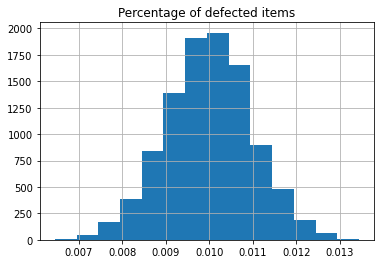

In [6]:
plot_hist(a, 1, "Yield")
plot_hist(b, 0.0005, "Percentage of defected items")

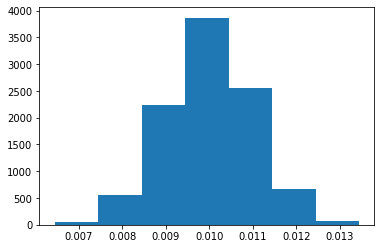

In [7]:
#plt.hist(a, bins=np.arange(a.min(), a.max()+1, 1))
plt.hist(b, bins=np.arange(b.min(), b.max(), 0.001))
plt.show()

In [154]:
def generateTimeSeries(months):
    
    date_rng = pd.date_range(start=datetime.date.today() - datetime.timedelta(months*365/12), 
                             end=datetime.date.today(), freq='H')
    df = pd.DataFrame(date_rng, columns=['Timestamp'])

    df1 = pd.DataFrame(range(1, num_machines+1), columns=['MachineID'])
    df2 = pd.DataFrame(range(1, num_prod_lines+1), columns=['ProdLineID'])

    df_tot = df2.merge(df1, how='cross')
    df_tot['FaultProb'] = random.choices(fault_prob, k = len(df_tot))
    df_tot = df.merge(df_tot, how='cross')
    
    df_tot['EnergyCons'] = gaussian_distr(scenarios["normal"]["avg_energy_cons"], 
                                          scenarios["normal"]["std_energy_cons"], len(df_tot))
    
    df_tot['Yield'] = gaussian_distr(scenarios["normal"]["avg_yield"], 
                                          scenarios["normal"]["std_yield"], len(df_tot))
    
    df_tot['DefectedItems'] = df_tot['Yield']*gaussian_distr(scenarios["normal"]["avg_perc_defects"], 
                                          scenarios["normal"]["std_perc_defects"], len(df_tot))
    
    
    return df_tot

In [221]:
df = generateTimeSeries(1)

In [222]:
df['CycMaintenance'] = 0
df.loc[df.index%30 == 0, 'CycMaintenance'] = 1
df['Fault'] = 0
#print(df['CycMaintenance'][df.index%30 == 0])

In [223]:
#print(df['ProdLineID'].unique())

for i in df['ProdLineID'].unique():
    #print(i)
    for j in df['MachineID'].unique():
        #print(str(i)+", "+str(j))
        #print(df[(df.ProdLineID == i) & (df.MachineID == j)]['FaultProb'].unique())
        temp = (df[(df.ProdLineID == i) & (df.MachineID == j)]).copy()
        temp = temp[['FaultProb','Fault']]
        #print(len(temp))
        temp['Fault'] = possoin_distr(temp['FaultProb'].unique(), len(temp))
        df.loc[temp.index , 'Fault'] = temp['Fault']

#print(df)

In [224]:
#print(list(scenarios.keys())[1:])
#print(random.choices(list(scenarios.keys())[1:], k = len(df[df.Fault == 1])))
df['FaultType'] = 'normal'
df.loc[df.Fault == 1, 'FaultType'] = random.choices(list(scenarios.keys())[1:], k = len(df[df.Fault == 1]))

In [225]:
print(df[df.Fault == 1])
print(df.FaultType.unique())

                Timestamp  ProdLineID  MachineID  FaultProb    EnergyCons  \
486   2022-01-29 09:00:00           4          7      0.005   9511.099214   
596   2022-01-29 11:00:00           5          7      0.003   9707.608191   
1512  2022-01-30 06:00:00           2          3      0.005  10204.214861   
2335  2022-01-30 22:00:00           4          6      0.003   9914.701240   
2890  2022-01-31 09:00:00           5          1      0.001   9989.497218   
...                   ...         ...        ...        ...           ...   
34854 2022-02-27 01:00:00           1          5      0.005  10207.583316   
34987 2022-02-27 03:00:00           4          8      0.005  10041.931832   
35189 2022-02-27 07:00:00           4         10      0.003  10203.156392   
35786 2022-02-27 19:00:00           4          7      0.005   9967.556309   
35980 2022-02-27 23:00:00           4          1      0.005   9603.653710   

             Yield  DefectedItems  CycMaintenance  Fault        FaultType  